In [1]:
import sad_nns.envs
import pandas as pd

pygame 2.5.2 (SDL 2.28.2, Python 3.11.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


/tmp/ipykernel_1282020/1806671208.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sb3_contrib
import torch
import gymnasium as gym
import stable_baselines3 as sb3

In [3]:
device = "cpu" if not torch.cuda.is_available() else "cuda:0"
# env = gym.make("Regression_Env", device=device, action_low=[0,-.001,0.0], action_high=[1,.1,0.6]) #making the action space more friendly
kwargs = {"action_low":[0,-.001,0.0,.4,0.0,0.0],    "action_high":[1,.1,0.6,1.0,1.0,1.0], "device":device}
env = gym.make("RegressionEnv-v0", device=device)
env = gym.wrappers.FlattenObservation(env)
# env = gym.make("NORTH_Regression_Env", device=device,seed=1, action_low=[0,-.001,0.0,.4,0.0,0.0], action_high=[1,.1,0.6,1.0,1.0,1.0]) #making the action space more friendly
env = gym.wrappers.FlattenObservation(env)

it was called


In [ ]:
model = sb3_contrib.RecurrentPPO("MlpLstmPolicy", env, verbose=1)
model.set_logger(sb3.common.logger.configure('./sb3_log', ["stdout", "csv", "tensorboard"]))
model.learn(10000,log_interval=5)

In [ ]:
df = pd.read_csv('./sb3_log/progress.csv')

In [ ]:
df.head()

,train/approx_kl,train/n_updates,train/clip_range,rollout/ep_rew_mean,time/total_timesteps,train/clip_fraction,time/iterations,train/std,time/fps,train/loss,train/explained_variance,rollout/ep_len_mean,time/time_elapsed,train/policy_gradient_loss,train/entropy_loss,train/learning_rate,train/value_loss
0,0.004427,40,0.2,-0.007888,640,0.003125,5,0.993910,5,-0.010256,-1.854931,2.93,121,-0.006971,-4.242402,0.0003,0.019266
1,0.014929,90,0.2,0.029910,1280,0.067969,10,0.986728,5,-0.032516,0.050830,3.40,236,-0.020237,-4.218651,0.0003,0.011752
2,0.001381,140,0.2,0.028605,1920,0.000000,15,0.982196,5,-0.010326,-0.205670,5.26,364,-0.006953,-4.204716,0.0003,0.013647
3,0.015340,190,0.2,0.056798,2560,0.123438,20,0.980102,5,-0.015177,0.160839,7.76,481,-0.010640,-4.198588,0.0003,0.009492
4,0.008162,240,0.2,0.086023,3200,0.075000,25,0.973979,5,-0.004652,0.464642,11.17,607,-0.002838,-4.179045,0.0003,0.010328


<Axes: >

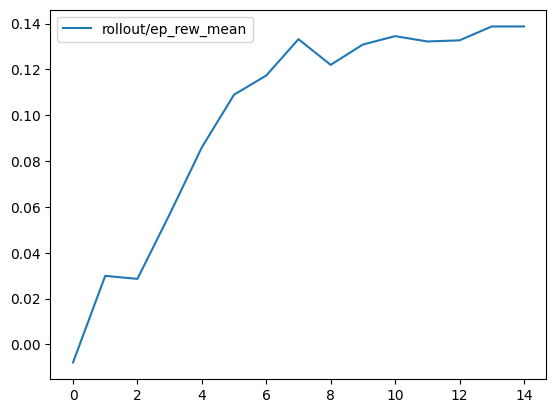

In [ ]:
df.plot(y='rollout/ep_rew_mean')

<Axes: >

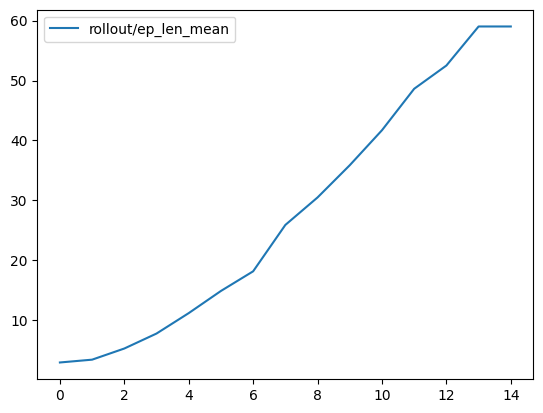

In [ ]:
df.plot(y="rollout/ep_len_mean")

In [11]:
from stable_baselines3.common.buffers import ReplayBuffer
import numpy as np
rb = ReplayBuffer(
        1_000_000,
        env.observation_space,
        env.action_space,
        device,
        handle_timeout_termination=False,
    )

In [14]:
data = {"reward":[],"cumulative_reward":[]}
obs, _ = env.reset(seed=5)
cumulative_reward = 0
infos = []
action = torch.tensor([0.001,0.1])
for i in range(70):
    new_obs, reward, done, _, info = env.step(action)
    infos.append(info)
    rb.add(obs,new_obs,action,reward,done,infos)
    obs=new_obs
    # data["step"].append(i)
    data["reward"].append(reward)
    cumulative_reward += reward
    data["cumulative_reward"].append(cumulative_reward)
    # print(cumulative_reward)
    if done:
        break
action[0] = 1
observation, reward, done, _, info = env.step(action)
infos.append(info)
rb.add(obs,observation,action,reward,done,infos)
# data["step"].append(i)
data["reward"].append(reward)
cumulative_reward += reward
data["cumulative_reward"].append(cumulative_reward)
cumulative_reward

0.45245510129023

<Axes: >

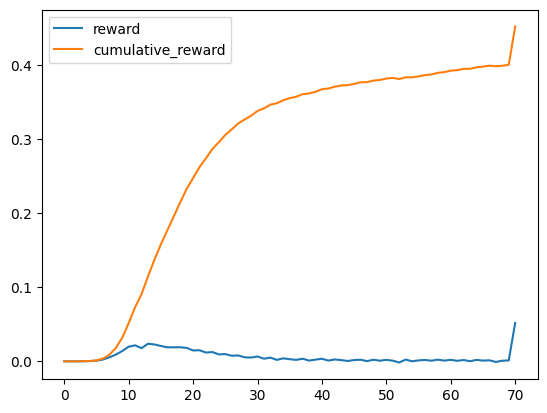

In [15]:
data = pd.DataFrame(data)
data.plot()

In [27]:
rb.sample(10).observations

tensor([[9.6000e+01, 4.0000e+00, 3.0749e+04, 5.9456e-02, 2.8000e+01, 6.0000e+00,
         7.4071e-01, 6.2200e+02, 7.5745e+04, 3.1088e+04, 1.9984e-01, 1.3327e+04,
         3.7000e+02, 1.6870e+04, 1.2700e+02],
        [9.6000e+01, 4.0000e+00, 3.0749e+04, 5.9456e-02, 9.0000e+00, 6.0000e+00,
         7.4071e-01, 6.2200e+02, 7.5745e+04, 3.1088e+04, 1.9984e-01, 2.4700e+04,
         3.7000e+02, 2.6580e+04, 1.2700e+02],
        [9.6000e+01, 4.0000e+00, 3.0749e+04, 5.9456e-02, 5.1000e+01, 6.0000e+00,
         7.4071e-01, 6.2200e+02, 7.5745e+04, 3.1088e+04, 1.9984e-01, 1.3164e+04,
         3.7000e+02, 1.6566e+04, 1.2700e+02],
        [9.6000e+01, 4.0000e+00, 3.0749e+04, 5.9456e-02, 1.9000e+01, 6.0000e+00,
         7.4071e-01, 6.2200e+02, 7.5745e+04, 3.1088e+04, 1.9984e-01, 1.3736e+04,
         3.7000e+02, 1.7156e+04, 1.2700e+02],
        [9.6000e+01, 4.0000e+00, 3.0749e+04, 5.9456e-02, 5.6000e+01, 6.0000e+00,
         7.4071e-01, 6.2200e+02, 7.5745e+04, 3.1088e+04, 1.9984e-01, 1.3149e+04,
      